------
# **Dynamic Classification of S&P 500 Stocks Using Distributed Computing and Fundamental Ratios**
------

-----

# **ST446 GROUP PROJECT**

## **Candidate Numbers: 49775, 50714, 49663, 49872**

----


#### **Note for Evaluator:**

--> **THIS NOTEBOOK IS ABOUT IMPLEMENTING ALL MODELS**

---> **Dataset link is uploaded in a pdf file named ST446 DATASET LINK.pdf file**

--> **Here Baseline - Classical models contains `"3 models"` and Gradient Boosting based contains `"3 models"`**



---

## **IMPLEMENTATION OF BASELINE MODELS - CLASSICAL ALGORITHMS (VANILLA MODELS) + BOOSTED AND GRADIENT BASED MODELS**

----

----

## **Overall Summary**

We developed a scalable pipeline to classify S&P 500 stocks into five performance categories (strong underperformance to strong outperformance) using fundamental ratios and macroeconomic indicators. Below is a summary of our approach in seven key points:

1. **Objective and Setup**  
   - We aimed to classify S&P 500 stocks based on quarterly performance using Apache Spark on a Google Cloud Dataproc cluster and implemented six models: **three baseline (Logistic Regression, Decision Tree, Random Forest) and three gradient-boosting-based (LightGBM, XGBoost, GBTClassifier with OneVsRest).**

2. **Data Acquisition and Preprocessing**  
   - We sourced data from Bloomberg Terminal, stored in Google Cloud Storage, joined financial and macroeconomic datasets, r`emoved 91 null rows`, filtered out the `SPX Index`, and retained `146,165 records` with `44 columns`.

3. **Exploratory Data Analysis (EDA)**  
   - We confirmed a clean dataset with no nulls, analyzed score distribution (skewed toward classes 1 and 5), computed correlations (strong within liquidity/profitability, weak with macros), and `used PCA/UMAP to assess feature dispersion and class separability`.

4. **Feature Engineering and Oversampling**  
   - We standardized 4`2 features (excluding `score`, `stock`, `date`)` using `VectorAssembler` and `StandardScaler`, and oversampled minority classes (scores 2, 3, 4) to balance the dataset, addressing class imbalance.

5. **Model Training and Pipeline**  
   - We built pipelines for all models, integrating feature assembly, scaling, and classification, trained on an `80-20 train-test split`, and saved models to Google Cloud Storage for scalability.

6. **Model Evaluation**  
   - We evaluated models using `accuracy, precision, recall, F1-score, and confusion matrices`; gradient-boosting models (e.g., LightGBM, XGBoost) outperformed baseline models, with XGBoost also assessed via multiclass ROC-AUC curves.

7. **Insights and Cleanup**  
   - We found macroeconomic and profitability features influential, but class imbalance and feature multicollinearity posed challenges; we unpersisted data and stopped the Spark session to optimize resources.

---

----
# **Cluster set up**
---


```bash
gcloud dataproc clusters create st446-cluster-final \
  --enable-component-gateway \
  --public-ip-address \
  --region=europe-west2 \
  --master-machine-type=n2-standard-2 \
  --master-boot-disk-size=100 \
  --num-workers=2 \
  --worker-machine-type=n2-standard-2 \
  --worker-boot-disk-size=200 \
  --image-version=2.2-debian12 \
  --optional-components=JUPYTER \
  --metadata='PIP_PACKAGES=lightgbm xgboost causalml scikit-learn pandas numpy matplotlib seaborn synapseml==0.11.1' \
  --initialization-actions='gs://st446-assignment-data/my_actions.sh' \
  --properties=^#^spark:spark.dynamicAllocation.enabled=false#spark:spark.jars.packages=ml.dmlc:xgboost4j-spark_2.12:1.6.1,com.microsoft.azure:synapseml_2.12:0.11.1 \
  --project=st446-wt2025-452419
```

---
### **Notes on Spark Properties**
---

To specify multiple Spark properties in `--properties`, a custom separator (`^#^`) is used to avoid syntax conflicts with colons or commas in Maven artifact strings. This syntax ensures that both configuration settings and external packages (e.g., XGBoost and SynapseML) are correctly passed at cluster creation. Defining multiple `--properties` flags across lines is not supported; only the last occurrence will take effect.


----
## **Install & Import important libraries**

---


In [ ]:
pip install lightgbm synapseml==0.11.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [lightgbm]1/2 [lightgbm]
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install umap-learn #for eda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [umap-learn]
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install sparkxgb # for xgboost

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 24.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'sparkxgb' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'sparkxgb'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for sparkxgb: filename=sparkxgb-0.2-py3-none-any.whl size=5628 sha256=3efa3ac8afa4f99abd3a5c05c5b2f64b276ab59f3b560667ef2e4819a19bbab8
  Stored in directory: /root/.cache/pip/wheels/f9/e5/73/8b34b9b0ba0e0793033077ead4ec8cb93329bcc71d53cfd7fc
  DEPRECATION: Building 'pyspark' using the legacy setup.py bdist_wheel mechanism, which will be removed in a

---
## **Import Necessary Libraries**

---

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnull, when, countDistinct, mean, stddev, min, max, udf
from pyspark.sql.types import DoubleType, ArrayType

from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, PCA
from pyspark.ml.classification import GBTClassifier, OneVsRest, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


from synapse.ml.lightgbm import LightGBMClassifier


from sparkxgb import XGBoostClassifier


from sklearn.preprocessing import StandardScaler as SklearnScaler
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from functools import reduce

import umap

from sklearn.metrics import roc_curve, roc_auc_score


from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

---
# **1. Introduction**

---

---
### **1.1. Background**
---

Equity markets function as platforms enabling the trading of company stocks, representing partial ownership in businesses. Beyond raising capital for growth, these markets offer investors opportunities for profit. Sustainable investment returns critically depend on identifying stocks with substantial growth potential, necessitating thorough macroeconomic insight and an understanding of company fundamentals. Financial statements, published quarterly and annually by publicly traded companies, provide reliable data for analyzing corporate fundamentals. These documents reveal insights into financial health, profitability, and operational effectiveness. Investors utilize financial statements for comparative analysis, facilitating the selection of high-performing stocks relative to market and sector benchmarks. The growing complexity and increasing volume of publicly listed companies highlight the need for automated stock classification systems. Algorithms incorporating fundamental financial data and macroeconomic indicators can significantly enhance investment decisions. Leveraging big data frameworks such as PySpark and Hadoop allows for the processing and analysis of large-scale financial datasets efficiently and effectively. These tools offer superior computational speed, scalability, and real-time data processing capabilities, enabling the construction of robust and accurate stock classification systems.

In this study, we will classify S&P 500 stocks into five distinct groups based on their quarterly performance. The S&P 500 index is chosen due to its comprehensive representation of various sectors of the U.S. economy, covering a wide range of industries and market capitalizations. Its extensive historical data and high liquidity make it particularly suitable for robust and scalable modeling. The primary objective is to identify optimal investment stocks using specific financial indicators derived from financial statements, thus enabling investors to make more informed decisions.

---
### **1.2. Related works**

---

Explanatory variables, sometimes referred to as factors, have long been studied by researchers in an effort to identify market inefficiencies and promote asset pricing. **Sharpe's Capital Asset Pricing Model (CAPM)** introduced beta as the first factor, followed by the multi-factor models of Fama and French, which incorporate size, value, and profitability dimensions. While factor-based approaches are widely used, traditional linear models often struggle to capture complex and nonlinear relationships between explanatory variables and returns.


In recent years, machine learning (ML) techniques have gained traction in stock selection due to their ability to model nonlinear patterns and improve predictive performance. For stock performance classification problem, recent precedents are as follows: Caparrini et al. employed tree-based classifiers -- Decision Tree, Random Forest, and XGBoost—to classify S&P 500 stocks based on expected profitability. They showed that retraining models over time enables portfolios to outperform the benchmark, with the best model achieving 40.4% accuracy. Tekin and Gümüşapplied clustering analysis based on financial ratios such as P/E and P/B to identify similar stocks for portfolio construction. Jidong and Ran utilized XGBoost to conduct stock selection based on financial fundamentals, and Fu et al. demonstrated the effectiveness of random forest classifiers in a similar context.

Building on these, our study tackles a multi-class classification task where S&P 500 stocks are assigned to five performance bands based on their benchmark-relative returns. To address the high dimensionality and volume of data, a scalable big-data pipeline on Apache Spark is applies. In addition to tree-based models, advanced algorithms such as **LightGBM, GBT combined with One-vs-Rest, and H2O AutoML** are also explored to assess whether more sophisticated techniques can enhance classification performance in high-dimensional financial data settings.

---
### **1.3. Research questions**

---

This study aims to investigate several key research questions, which include but are subject to change based on data limitations and practical constraints associated with big data analytics:

- Which fundamental factors consistently exhibit positive or negative impacts on stock performance?

- What are the most influential factors determining stock performance within the S&P 500?

- How effectively can selected macroeconomic and fundamental indicators predict stock performance?

- What limitations exist when using fundamental and macroeconomic variables within big data frameworks to predict stock performance?

These questions are designed to provide comprehensive insights while acknowledging inherent methodological and data-related challenges in big data applications.

---
# **2. Data selection & Methodology**
---

---
### **2.1. Data selection**

---

This study classifies S&P 500 stocks using both **firm-specific financial ratios** and **macroeconomic indicators**. These two variable sets reflect, respectively, the internal financial health of firms and the external economic environment. Their integration captures the multidimensional basis upon which investors assess risk, value and return. On one hand, macro indicators influence both systematic risk and investor sentiment, they play a central role in how stocks are priced and classified across economic regimes, while  financial ratios contribute directly to stock classification and market performance by influencing how investors assess firm quality and risk.

---

**(1) Macroeconomic Indicators**

- **Macroeconomic indicators** reflect the environment in which firms operate. Investors use these signals to adjust earnings forecasts, risk appetite and portfolio allocations.

- **Growth indicators**, such as GDP and PMI, capture overall economic momentum. When growth is strong, investors anticipate improved corporate earnings, particularly for cyclical firms, and respond by reweighting toward equities (*Mankiw, 2019*).

- **Inflation and interest rate metrics**, including CPI, the Fed Funds Rate and Treasury yields, affect discount rates and funding costs. When rates rise, the present value of future cash flows declines, prompting shifts from growth stocks to more defensive assets (*Fabozzi, 2015*).

- **Consumer and labour data**, such as unemployment and retail sales, signal income and spending trends. Investors interpret strong household demand as supportive of revenue growth and equity valuations, especially in consumer-sensitive sectors.

**(2) Financial Ratios**

- **Financial ratios** provide a structured view of firm characteristics. Investors interpret these ratios to evaluate risk and return, which in turn shapes pricing and classification outcomes.

- **Liquidity ratios**, such as the current and quick ratios, indicate a firm’s capacity to meet short-term liabilities. When these ratios are high, investors perceive lower liquidity risk, particularly during market stress, leading to stronger demand for the stock (*White et al., 2003*).

- **Leverage and solvency ratios**, including debt-to-equity and interest coverage, reveal the firm’s capital structure and exposure to financial distress. Firms with high leverage are more vulnerable to earnings shocks and interest rate hikes, prompting investors to demand higher returns and often resulting in lower valuation multiples (*Altman, 1968*).

- **Profitability indicators**, like ROE and net profit margin, measure how efficiently a firm turns capital into earnings. High and stable profitability signals operating strength, which enhances investor confidence and supports favourable valuation (*Penman, 2013; Piotroski, 2000*).

- **Valuation ratios**, such as P/E and EV/EBITDA, express how markets price the firm relative to fundamentals. While low multiples may indicate undervaluation, they can also signal risk. The investor’s interpretation of these ratios—shaped by both expectations and behavioural biases—influences capital flows and market pricing (*Damodaran, 2012; Lakonishok et al., 1994*).

---



---
### **2.2. Data description**

---

The dependent variable in this study is a categorical indicator representing the **relative performance** of each stock compared to the benchmark index, the S&P 500. Let **x** denote the total return of the S&P 500 over a specified period and **y** the return of the individual stock over the same interval. The ratio y/x is used to construct a **five-class ordinal variable**, capturing the degree of excess return.

This benchmark-relative classification approach enables the identification of stocks that **materially underperform, align with, or outperform** the market. It provides a more nuanced assessment of return patterns than binary classification, and is commonly employed in **performance attribution** and **active portfolio management** frameworks (Sharpe, 1994).

The classification scheme is presented in Table X.

**Table 1. Construction of classification target variable**

| **Class Label** | **Return Condition**      | **Relative Performance with Benchmark**                                |
|-----------------|---------------------------|------------------------------------------------------------------------|
| 1               | y < 0.5x                  | Strong underperformance                      |
| 2               | 0.5x ≤ y < 0.9x           | Slight underperformance                                                 |
| 3               | 0.9x ≤ y < 1.1x           | Neutral performance                          |
| 4               | 1.1x ≤ y < 1.5x           | Slight outperformance                                                   |
| 5               | y ≥ 1.5x                  | Strong outperformance                      |

**Table 2: Features of classification task**

| **Type**    | **Category**    | **Indicator**                        | **Explanation and effect on performance**                                                                                             | **Frequency** | **Data Type** | **Time Period**     | **Collection Method**            |
|-------------|-----------------|--------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------|---------------|---------------|---------------------|-----------------------------------|
| Feature     | Liquidity       | Current Ratio                        | Measures ability to pay short-term obligations; higher values reduce perceived liquidity risk                                        | Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Liquidity       | Quick Ratio                          | Excludes inventory; higher values indicate stronger short-term liquidity                        | Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Liquidity       | Cash Ratio                           | Focuses on cash-only coverage; high values enhance stability but may imply idle capital          | Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Solvency        | Debt-to-Equity Ratio                 | High values reflect heavy leverage and potential financial risk                                 | Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Solvency        | Debt Ratio                           | Indicates proportion of assets financed by debt; high ratios signal financial vulnerability      | Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Solvency        | Interest Coverage Ratio              | Measures debt servicing ability; high values reduce default risk                                | Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Profitability   | Return on Assets (ROA)               | Efficiency in using assets to generate net income; high ROA supports superior firm performance  | Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Profitability   | Return on Equity (ROE)               | Indicates return generated on shareholders’ equity; high ROE attracts equity investors           | Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Profitability   | Net Profit Margin                    | Measures profitability after all expenses; high margins reflect strong bottom-line control       | Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Profitability   | Operating Margin                     | Captures operational efficiency; higher values enhance earnings stability                        | Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Profitability   | Gross Margin                         | Measures core production profitability; high margins indicate pricing power                      | Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Valuation       | Price-to-Earnings (P/E)              | Lower P/E may suggest undervaluation; higher P/E implies growth expectations or overpricing      | Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Valuation       | Price-to-Book (P/B)                  | Compares market value to book equity; low P/B may signal value opportunities                     | Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Valuation       | Price-to-Sales (P/S)                 | Relates market cap to revenue; lower values may reflect discounted market pricing                | Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Valuation       | Price-to-Cash Flow                   | Indicates valuation relative to operating cash; low values may attract long-term investors       | Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Valuation       | EV/EBITDA                            | Assesses firm value relative to core earnings; low ratios often preferred for acquisition targets| Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Valuation       | Dividend Yield                       | Measures income return; high yield may indicate maturity or undervaluation                      | Quarterly     | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Macroeconomic   | GDP Growth (%)                       | Reflects economic expansion; higher growth supports earnings potential and equity sentiment      | Monthly       | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Macroeconomic   | CPI (%)                              | Measures inflation; high CPI may erode purchasing power and raise rates                          | Monthly       | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Macroeconomic   | PMI                                   | Business activity index; values above 50 signal expansion and boost market confidence            | Monthly       | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Macroeconomic   | Unemployment Rate (%)                | High unemployment suggests weak labour demand and consumption, reducing market optimism          | Monthly       | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Macroeconomic   | Retail Sales Growth (%)              | Higher sales reflect strong consumer demand, benefiting revenue generation                       | Monthly       | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Macroeconomic   | Net Export Growth (%)                | Indicates trade performance; positive growth supports export-driven sectors                      | Monthly       | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Macroeconomic   | IIP (Industrial Production Index)    | Tracks real output in goods-producing sectors; growth supports cyclical equities                 | Monthly       | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Macroeconomic   | 10-year Treasury Yield (%)           | Higher yields raise discount rates, pressuring valuations, especially for growth stocks          | Monthly       | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Macroeconomic   | Saving Rate (%)                      | High saving rates reduce consumption, potentially slowing revenue growth                         | Monthly       | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Macroeconomic   | New Home Sales Growth (%)            | Higher growth signals economic confidence and real estate strength                               | Monthly       | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |
| Feature     | Macroeconomic   | Fed Funds Rate (%)                   | Higher rates increase cost of capital and reduce equity attractiveness                           | Monthly       | Numeric       | 01/2009 – 12/2024    | Bloomberg Terminal                 |

---
**Data acquisition and preparation**


The dataset used in this study consists of monthly fundamental and macroeconomic indicators for S&P 500 companies, originally sourced from the Bloomberg Terminal. The raw data were uploaded to a Google Cloud Storage (GCS) bucket (`st446-assignment-data`) to enable scalable and distributed data processing via Apache Spark.

To unify the datasets, macroeconomic and firm-level financial data were joined on the `month` key using PySpark's distributed join operations. A null-check pipeline was implemented in Spark to identify rows with incomplete information across any of the 44 features. A total of 91 rows with missing values were removed using `dropna()`, leveraging Spark’s parallel filtering and transformation capabilities to maintain computational efficiency at scale.

Redundant columns, including market-level returns and identifiers, were subsequently dropped to reduce feature dimensionality and optimize downstream model performance. The resulting dataset, containing 146,165 records, was fully cleaned and preprocessed using Spark DataFrames, providing a structured and high-throughput-ready foundation for large-scale machine learning experiments.

---


---
# **Data acquisition**

---

In [ ]:
# Create Spark session
spark = SparkSession.builder.getOrCreate()

# Set bucket name
bucket = 'st446-assignment-data1'

# Define file paths
fundamental_path = f'gs://{bucket}/st446_trading_and_fundamental_data_bbg.csv'
macro_path = f'gs://{bucket}/st446_macro_data.csv'

# Read CSV files into DataFrames
fundamental_df = spark.read.csv(fundamental_path, header=True, inferSchema=True)
macro_df = spark.read.csv(macro_path, header=True, inferSchema=True)

---
# **Data Preprocessing**

---

In [ ]:
macro_df = macro_df.withColumnRenamed('date', 'macro_date')

In [ ]:
data_df = fundamental_df.join(macro_df, on='month', how='left')
data_df = data_df.drop('macro_date', 'month','quarter','year','px_last','cur_mkt_cap','logret','spx_logret')

---
## **Identifying Null Rows**
---

In [ ]:
# Count rows that have any nulls
null_rows = data_df.filter(
    sum(col(c).isNull().cast("int") for c in data_df.columns) > 0
)

# Show how many rows have at least one NULL
print("Number of rows with at least one NULL:", null_rows.count())


25/05/06 00:48:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Number of rows with at least one NULL: 91


---
## **Remove NaN's**

---

In [ ]:
data = data_df.dropna(how='any')

---
## **Data Filtering**

---

In [ ]:
# Filter the data of SPX index
data = data.filter(data.stock != 'SPX Index')

---
## **Data Properties**

---

In [ ]:
# Count rows
n_rows = data.count()

# Count columns
n_cols = len(data.columns)

# Print shape
print(f"DataFrame shape: ({n_rows}, {n_cols})")

DataFrame shape: (146165, 44)


---
## **Final Dataset**

---

In [ ]:
# Show the data
data.show(5,truncate=False)

+-----+----------+-----+----------------+---------+-----------+----------+-------------------+---------------------+-----------------------+------------+-----------+-----------+---------------+--------------+--------------+-------------+------------------------------+-------------+--------+----------------+-----------------+--------------+---------+---------------+--------------+------------+------------+-------------------+------------------+------------------+----------------+---------------+----------+----+-----------------+------------+-----------------+----------------------------+---------------------+--------------+-------------+------------+----------+
|stock|date      |score|market_cap_score|cur_ratio|quick_ratio|cash_ratio|tot_debt_to_tot_eqy|tot_debt_to_tot_asset|interest_coverage_ratio|gross_margin|oper_margin|prof_margin|return_on_asset|return_com_eqy|asset_turnover|acct_rcv_turn|accounts_payable_turnover_days|acct_rcv_days|pe_ratio|px_to_book_ratio|px_to_sales_ratio|divid

---
# **3. Exploratory Data Analysis (EDA)**

----

Our final data has 44 columns, with the `score` target column, and 42 `features` which include the monthly data of fundamental ratios and macroeconomic indicators of each stock from 2009 to 2024. All of the target and features columns are numbers.

The dataset includes 146,165 records across 44 columns, spanning fundamental ratios and macroeconomic indicators. All variables were confirmed as numeric or temporal types. Data schema and completeness were verified using PySpark's distributed API, and no significant missingness was detected across any feature.

Descriptive statistics were computed in parallel using `data.describe()`. Feature variances and outlier magnitudes indicate the need for robust scaling before model training.

The `score` target variable shows a highly imbalanced distribution, with classes 1 and 5 dominating the sample. This highlights the importance of class rebalancing methods such as weighted metrics or sampling strategies in subsequent modeling stages.

---
## **Our Data Schema**

---

In [ ]:
print("Schema:")
data.printSchema()

print("\nRow count:", data.count())
print("Column count:", len(data.columns))

Schema:
root
 |-- stock: string (nullable = true)
 |-- date: string (nullable = true)
 |-- score: double (nullable = true)
 |-- market_cap_score: integer (nullable = true)
 |-- cur_ratio: double (nullable = true)
 |-- quick_ratio: double (nullable = true)
 |-- cash_ratio: double (nullable = true)
 |-- tot_debt_to_tot_eqy: double (nullable = true)
 |-- tot_debt_to_tot_asset: double (nullable = true)
 |-- interest_coverage_ratio: double (nullable = true)
 |-- gross_margin: double (nullable = true)
 |-- oper_margin: double (nullable = true)
 |-- prof_margin: double (nullable = true)
 |-- return_on_asset: double (nullable = true)
 |-- return_com_eqy: double (nullable = true)
 |-- asset_turnover: double (nullable = true)
 |-- acct_rcv_turn: double (nullable = true)
 |-- accounts_payable_turnover_days: double (nullable = true)
 |-- acct_rcv_days: double (nullable = true)
 |-- pe_ratio: double (nullable = true)
 |-- px_to_book_ratio: double (nullable = true)
 |-- px_to_sales_ratio: double (nu


Row count: 146165
Column count: 44


After removing all the NaN values in the preprocessing test, we check that there is any NULL value remained. We now confirm that our data is free from NULL value.

---
## **Identifying Null Values**

---

In [ ]:
print("\nNull values per column:")
data.select([
    count(when(col(c).isNull(), c)).alias(c) for c in data.columns
]).show(truncate=False)


Null values per column:


+-----+----+-----+----------------+---------+-----------+----------+-------------------+---------------------+-----------------------+------------+-----------+-----------+---------------+--------------+--------------+-------------+------------------------------+-------------+--------+----------------+-----------------+--------------+---------+---------------+--------------+------------+------------+-------------------+------------------+------------------+----------------+---------------+----------+---+-----------------+------------+-----------------+----------------------------+---------------------+--------------+-------------+------------+----------+
|stock|date|score|market_cap_score|cur_ratio|quick_ratio|cash_ratio|tot_debt_to_tot_eqy|tot_debt_to_tot_asset|interest_coverage_ratio|gross_margin|oper_margin|prof_margin|return_on_asset|return_com_eqy|asset_turnover|acct_rcv_turn|accounts_payable_turnover_days|acct_rcv_days|pe_ratio|px_to_book_ratio|px_to_sales_ratio|dividend_yield|ev_

---
## **Descriptive Statisitcs**

---

In [ ]:
print("\nDescriptive stats :")
data.describe().show(truncate=False)


Descriptive stats :


We also check the number of stocks remained after cleaning the data. We got 473 stocks remained per 502 stocks. Other stocks are excluded due to limitation of the data.  

In [ ]:
print("\nDistinct stock count:")
data.select("stock").distinct().count()


Distinct stock count:


473

Now we inspect more about the target `score` and the features

In [ ]:
target = data.select('score')
features_cols = [col for col in data.columns if col not in ['date','stock','score']]
features = data.select(features_cols)

The score distribution is heavily skewed toward classes 1 and 5, which represent extreme underperformance and outperformance. These outcomes are more common because mid- and small-cap stocks tend to show greater volatility than the benchmark. In contrast, intermediate classes (2, 3 and 4) appear less frequently due to both narrower return thresholds and the lower probability of stocks staying close to the index. This imbalance poses a modelling challenge. Without correction, models may favour dominant classes and overlook neutral or moderate outcomes. We therefore need to apply class-balancing techniques or weighted metrics to ensure fairer predictions.

---
# **Score Distribution Analysis**

---

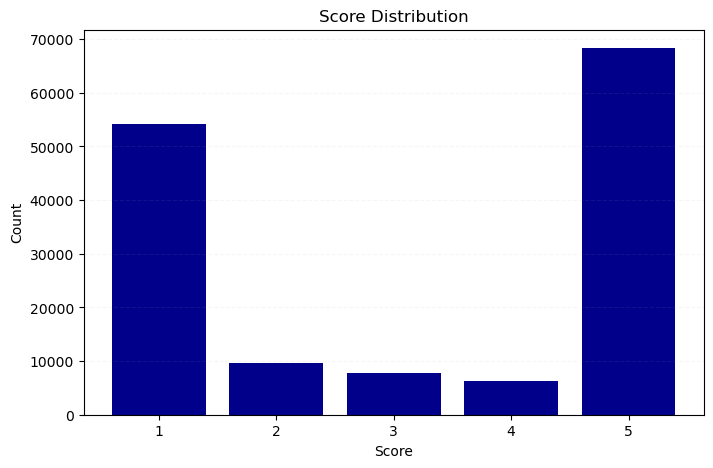

In [ ]:
# Group by score and count
score_counts = target.groupBy("score").count().orderBy("score")
score_pd = score_counts.toPandas()

plt.figure(figsize=(8,5))
plt.bar(score_pd['score'], score_pd['count'], color='darkblue')
plt.title("Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.xticks(score_pd['score'])
plt.grid(axis='y', linestyle='--', alpha=0.1)
plt.show()

---
We also run the correlation heatmap for our features. Based on the correlation heatmap result:

- Fundamental ratios exhibit strong correlation in some groups of ratios, particularly within liquidity and profitability. This reflects overlapping construction formulas—such as between `oper_margin`, `gross_margin`, `prof_margin` - but we retain them, as each ratio captures a different operational or financial angle of companies.

- Macroeconomic indicators show weak to moderate correlation with firm-level metrics. Variables like `gdp_growth`, `cpi`, and `unemployment_rate` appear largely orthogonal to company fundamentals, suggesting they contribute independent and complementary signals to the model.

- A few features exhibit negative correlation, such as `dividend_yield` vs. `px_to_book_ratio`, which may affect interpretability in models that rely on linear relationships.

---


---
# **Correlation Heatmap**

---

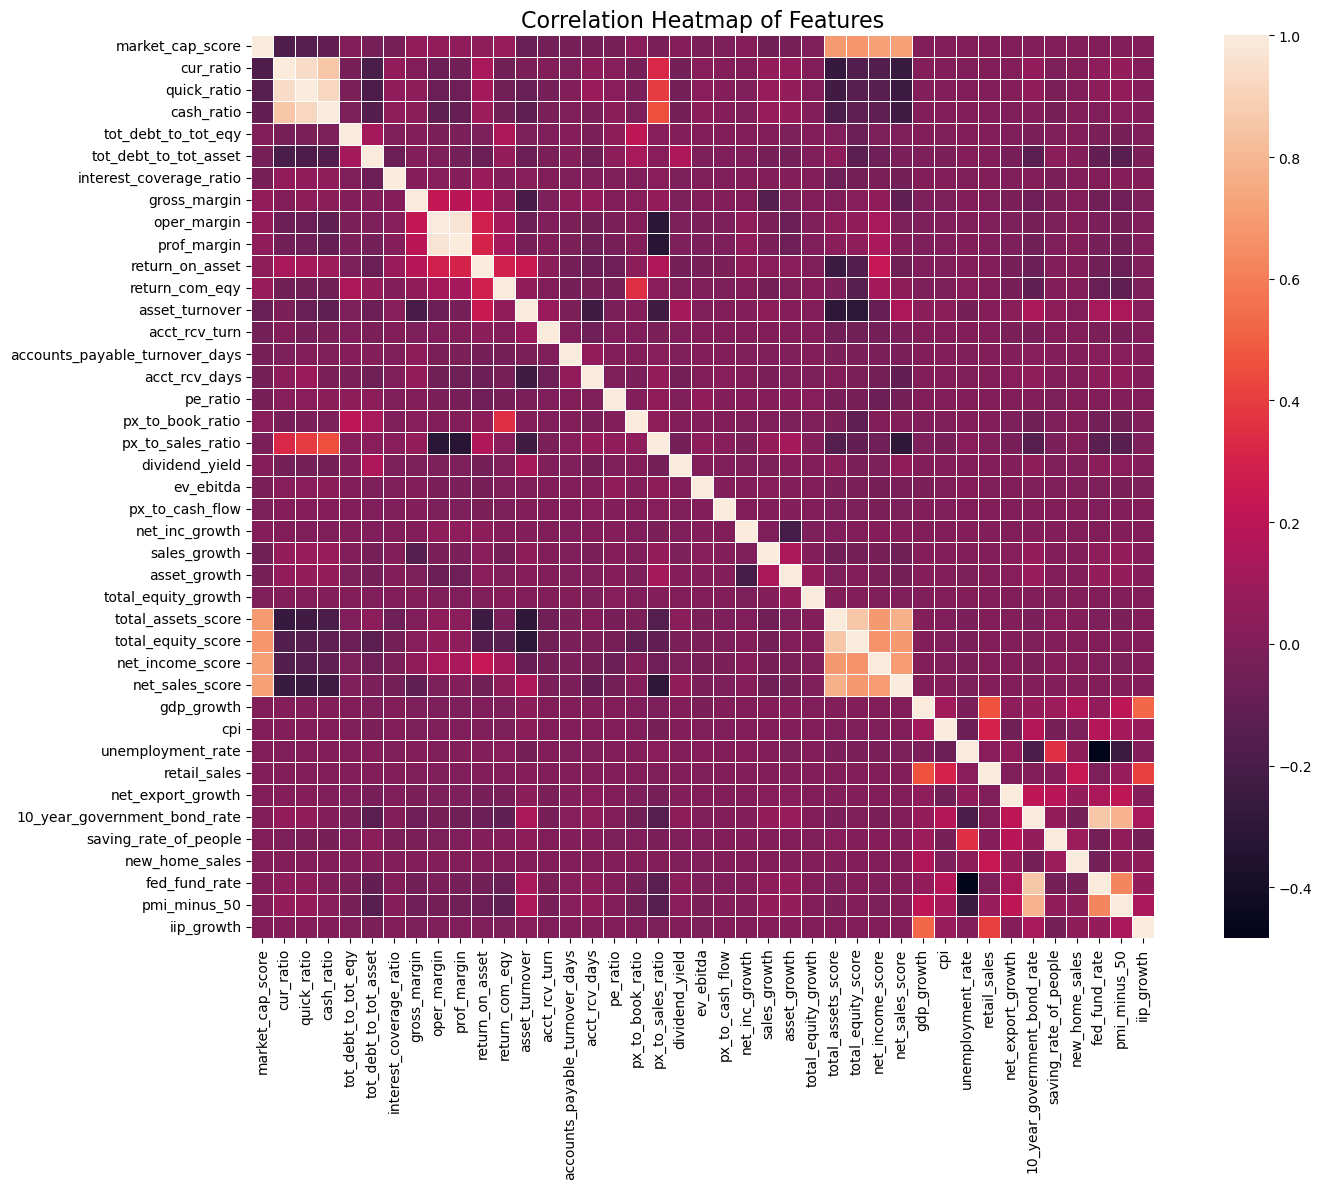

In [ ]:
features_pd = features.toPandas()

# Compute correlation matrix
corr_matrix = features_pd.corr()

# Plot heatmap
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, cmap='rocket', square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Features", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---
To assess feature redundancy and the concentration of information, we applied Principal Component Analysis (PCA) on the standardized features. PCA helps reduce dimensionality by projecting the data into a lower-dimensional space while preserving as much variance as possible.

We extracted the top 10 principal components to evaluate how much variance they can collectively explain. The result shows that these ten components account for approximately **52.89%** of the total variance. This indicates that the information is relatively dispersed across many features, and no small subset of components captures most of the variance.

As a result, we decided to retain all original features for the downstream modeling phase to preserve the full information content.

---


---
# **Feature Engineering**

---

In [ ]:
# get the feature columns
feature_cols = [c for c in data.columns if c not in ["score", "stock", "date"]]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_assembled = assembler.transform(data)

In [ ]:
# standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(data_assembled)
data_scaled = scaler_model.transform(data_assembled)


---
# **Principle Component Analysis**

---

In [ ]:
# Perform PCA
pca = PCA(k=10, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(data_scaled)
data_pca = pca_model.transform(data_scaled)


In [ ]:
print("Explained Variance for each principal component:")
for i, variance in enumerate(pca_model.explainedVariance.toArray()):
    print(f"PC{i+1}: {variance:.4f}")


Explained Variance for each principal component:
PC1: 0.1080
PC2: 0.0744
PC3: 0.0682
PC4: 0.0572
PC5: 0.0490
PC6: 0.0405
PC7: 0.0373
PC8: 0.0349
PC9: 0.0305
PC10: 0.0289


----

To better understand the distribution of the financial features we used, we applied UMAP (Uniform Manifold Approximation and Projection) for dimensionality reduction and visualization. We first standardized the original features, and then used UMAP to project the high-dimensional data into a two-dimensional space, allowing us to observe the separability among different score classes.

From the resulting plot, we can observe that all samples are mainly clustered into two large groups. However, each cluster contains a mixture of different score categories. In particular, samples with scores of 1 and 5 are widely distributed across both clusters, and there is no clear boundary between the classes. This suggests that the original features may not be sufficient to distinguish all categories effectively, and even complex models may not achieve high classification accuracy.

This observation is consistent with findings in related literature: due to multicollinearity among financial features and the non-separable nature of the labels, traditional structured learning methods face certain limitations. Therefore, in the modeling phase, we incorporate strategies such as ensemble methods and oversampling to compensate for the limited discriminative power of the features.

---


---
## **Data Sampling and Scaling**

---

In [ ]:
# Step 1: sample the data
sample_df = data.sample(fraction=0.01, seed=42).limit(2000)
pdf = sample_df.select("score", *feature_cols).toPandas()

# Step 2: scale the data

X = pdf[feature_cols].values
y = pdf["score"].values

scaler = SklearnScaler()
X_scaled = scaler.fit_transform(X)



---
## **UMAP Projection of Scores**

---

/opt/conda/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


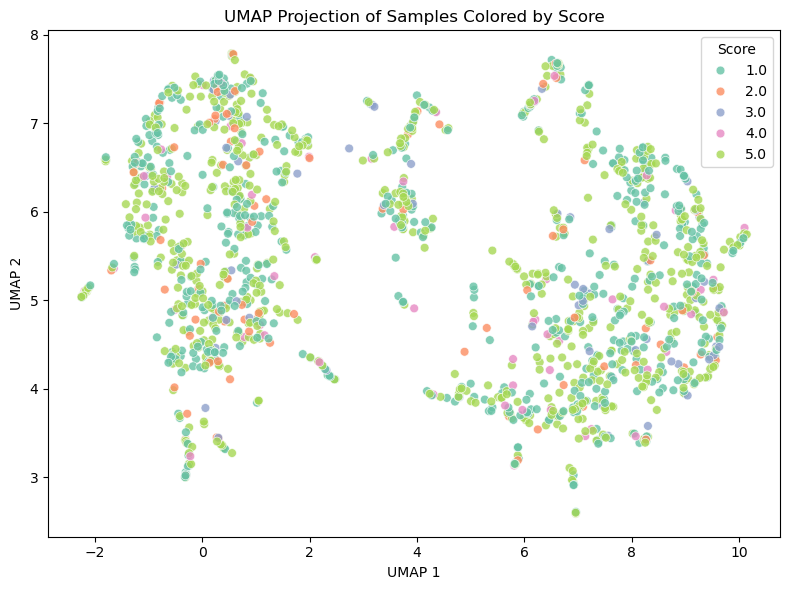

In [ ]:
reducer = umap.UMAP(
    n_neighbors=15,       # control local vs global structure
    min_dist=0.01,         # control how tightly points are packed together
    n_components=2,       # 2D
    metric='euclidean',
    random_state=42
)
embedding = reducer.fit_transform(X_scaled)

# Step 3: visualize the data
umap_df = pd.DataFrame(embedding, columns=["UMAP 1", "UMAP 2"])
umap_df["Score"] = y

plt.figure(figsize=(8,6))
sns.scatterplot(data=umap_df, x="UMAP 1", y="UMAP 2", hue="Score", palette="Set2", s=40, alpha=0.8)
plt.title("UMAP Projection of Samples Colored by Score")
plt.legend(title="Score")
plt.tight_layout()
plt.show()

--------------------------------------------------------------------------
# 4. **Modelling**
--------------------------------------------------------------------------

---
## **Evaluation tools**
---

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import pandas as pd

---
## **Build Performance Metrics**
---

In [ ]:
def evaluate_metrics(predictions, label_col="score_index", prediction_col="prediction", model_name="Model"):
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator

    evaluator_f1 = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="f1")
    evaluator_acc = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="accuracy")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="weightedRecall")

    print(f"\n{model_name} Evaluation Metrics:")
    print(f"F1 Score:   {evaluator_f1.evaluate(predictions):.4f}")
    print(f"Accuracy:   {evaluator_acc.evaluate(predictions):.4f}")
    print(f"Precision:  {evaluator_precision.evaluate(predictions):.4f}")
    print(f"Recall:     {evaluator_recall.evaluate(predictions):.4f}")


---
## **Build Confusion Matrix**
---

In [ ]:
def plot_confusion_matrix(predictions, label_col="score_index", prediction_col="prediction", model_name="Model"):
    y_true = predictions.select(label_col).toPandas()
    y_pred = predictions.select(prediction_col).toPandas()

    cm = confusion_matrix(y_true, y_pred)
    labels = sorted(y_true[label_col].unique())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({model_name})")
    plt.tight_layout()
    plt.show()

    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    df_report = pd.DataFrame(report).transpose()
    print(f"\nClassification Report ({model_name}):")
    display(df_report)


---
## **Build Multiclass AUC-ROC Plot**
---

In [ ]:
def plot_multiclass_roc(predictions, label_col="score_index", prob_col="probability", model_name="Model"):
    from sklearn.preprocessing import label_binarize

    y_true = predictions.select(label_col).toPandas()
    y_score = np.array(predictions.select(prob_col).rdd.map(lambda row: row[0]).collect())

    classes = sorted(np.unique(y_true))
    y_bin = label_binarize(y_true[label_col], classes=classes)

    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        auc = roc_auc_score(y_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({model_name})")
    plt.legend()
    plt.tight_layout()
    plt.show()

--------------------------
## 1. **Label Indexing**
--------------------------

In [ ]:
# StringIndex (already exists, if you first run, we need to add)
indexer = StringIndexer(inputCol="score", outputCol="score_index", handleInvalid="skip")
data = indexer.fit(data).transform(data)



--------------------------
## 2. **Oversample Minority Classes**
--------------------------


In [ ]:
# Oversample（score_index）
max_count = data.groupBy("score_index").count().agg({"count": "max"}).collect()[0][0]
classes = data.select("score_index").distinct().rdd.flatMap(lambda x: x).collect()

oversampled_data = []
for cls in classes:
    subset = data.filter(col("score_index") == cls)
    current_count = subset.count()
    if current_count < max_count:
        ratio = max_count / current_count
        sampled = subset.sample(withReplacement=True, fraction=ratio, seed=42)
        oversampled_data.append(sampled)
    else:
        oversampled_data.append(subset)

data_balanced = oversampled_data[0]
for d in oversampled_data[1:]:
    data_balanced = data_balanced.union(d)

--------------------------
## 3. **Feature Engineering**
--------------------------

In [ ]:
feature_cols = [c for c in data.columns if c not in ["score", "score_index", "stock", "date", "weight"]]
print("Selected Feature Columns:", feature_cols)

Selected Feature Columns: ['market_cap_score', 'cur_ratio', 'quick_ratio', 'cash_ratio', 'tot_debt_to_tot_eqy', 'tot_debt_to_tot_asset', 'interest_coverage_ratio', 'gross_margin', 'oper_margin', 'prof_margin', 'return_on_asset', 'return_com_eqy', 'asset_turnover', 'acct_rcv_turn', 'accounts_payable_turnover_days', 'acct_rcv_days', 'pe_ratio', 'px_to_book_ratio', 'px_to_sales_ratio', 'dividend_yield', 'ev_ebitda', 'px_to_cash_flow', 'net_inc_growth', 'sales_growth', 'asset_growth', 'total_equity_growth', 'total_assets_score', 'total_equity_score', 'net_income_score', 'net_sales_score', 'gdp_growth', 'cpi', 'unemployment_rate', 'retail_sales', 'net_export_growth', '10_year_government_bond_rate', 'saving_rate_of_people', 'new_home_sales', 'fed_fund_rate', 'pmi_minus_50', 'iip_growth']


--------------------------
## 4. **Train-Test Split**
--------------------------


In [ ]:
train_data, test_data = data_balanced.randomSplit([0.8, 0.2], seed=42)

-------------------------
## 5. **Define Features Pipeline**
-------------------------

In [ ]:
# Feature pipeline
assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")

scaler = StandardScaler(inputCol="raw_features", outputCol="features")

----------------------------------------------------

# 6. **BASELINE VANILLA MODELS**

-----------------------------------------------------

## **Logistic Regression**

------------------------------------------------------------------
## **Logistic Regression Model and its Pipeline Setup**
------------------------------------------------------------------

In [ ]:
# Logistic Regression
lr = LogisticRegression(labelCol="score_index", featuresCol="features", maxIter=10)

# Full pipeline
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])

## **Logistic Regression Training**

In [ ]:
model_lr = pipeline_lr.fit(train_data)

## **Save Model Results**

In [ ]:
# 8. Save model
model_lr.write().overwrite().save(f'gs://{bucket}/models/LogisticRegression')

## **Predicting Logistic Regression Results**

In [ ]:

predictions_lr = model_lr.transform(test_data)


## 8. **Performance Metrics**


In [ ]:
evaluate_metrics(predictions_lr, model_name="Logistic Regression")


Logistic Regression Evaluation Metrics:


F1 Score:   0.2291


Accuracy:   0.2356


Precision:  0.2357


Recall:     0.2356


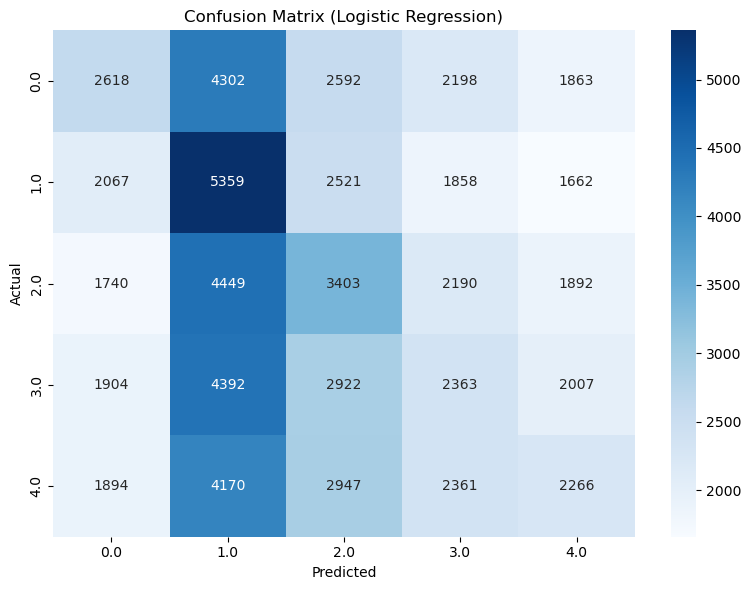


Classification Report (Logistic Regression):


,precision,recall,f1-score,support
0.0,0.256089,0.192883,0.220037,13573.000000
1.0,0.236371,0.397936,0.296577,13467.000000
2.0,0.236566,0.248866,0.242560,13674.000000
3.0,0.215406,0.173903,0.192442,13588.000000
4.0,0.233849,0.166153,0.194273,13638.000000
accuracy,0.235634,0.235634,0.235634,0.235634
macro avg,0.235656,0.235948,0.229178,67940.000000
weighted avg,0.235650,0.235634,0.229051,67940.000000


In [ ]:
plot_confusion_matrix(predictions_lr, model_name="Logistic Regression")

**Summary**:

Logistic Regression performed poorly, with low metrics across the board **(accuracy ~23.6%)**. The classification report shows balanced but weak performance across all classes **(F1-scores ~0.19–0.30)**, with class 1 (slight underperformance) having the highest **recall (0.40)**. This suggests the model struggles to capture complex patterns in the data, likely due to its linear assumptions, making it the weakest baseline model.

-------------------------------------------------
# **Decision Tree**
-------------------------------------------------

In [ ]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="score_index", featuresCol="features")

## **Model Pipeline**

In [ ]:
pipeline_dt = Pipeline(stages=[assembler, scaler, dt])

## **Training Decision Tree**

In [ ]:
model_dt = pipeline_dt.fit(train_data)

## **Save model**

In [ ]:
# 8. Save model
model_dt.write().overwrite().save(f'gs://{bucket}/models/DecisionTree')

## **Big Data Specifics on Decision Tree**

In [ ]:
dt_model = model_dt.stages[-1]
print("Best maxDepth:", dt_model.getOrDefault("maxDepth"))
print("Best maxBins:", dt_model.getOrDefault("maxBins"))

Best maxDepth: 5
Best maxBins: 32


## **Model Prediction**

In [ ]:
predictions_dt = model_dt.transform(test_data)

## **Performance Metrics**

In [ ]:
evaluate_metrics(predictions_dt, model_name="Decision Tree")


Decision Tree Evaluation Metrics:


F1 Score:   0.1796


Accuracy:   0.2337


Precision:  0.2757


Recall:     0.2337


## **Decision Tree Confusion Matrix**

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


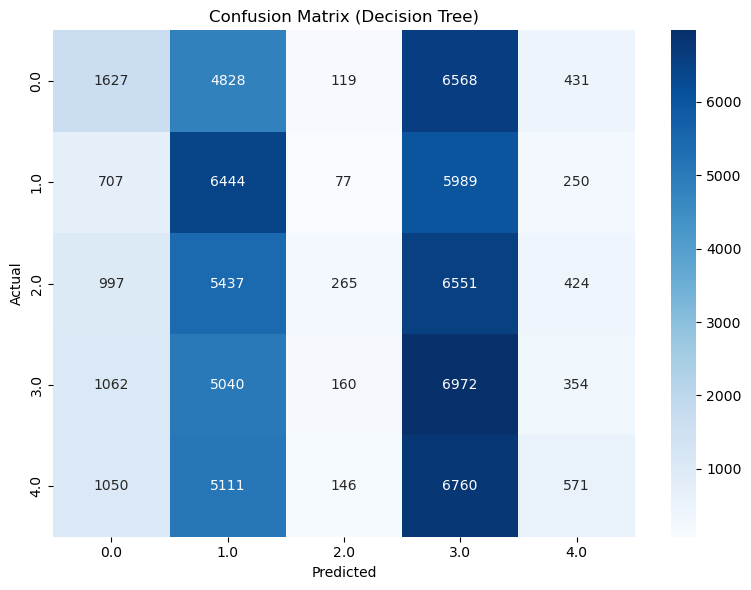


Classification Report (Decision Tree):


,precision,recall,f1-score,support
0.0,0.298916,0.119870,0.171119,13573.000000
1.0,0.239911,0.478503,0.319587,13467.000000
2.0,0.345502,0.019380,0.036701,13674.000000
3.0,0.212302,0.513100,0.300336,13588.000000
4.0,0.281281,0.041868,0.072887,13638.000000
accuracy,0.233721,0.233721,0.233721,0.233721
macro avg,0.275582,0.234544,0.180126,67940.000000
weighted avg,0.275733,0.233721,0.179619,67940.000000


In [ ]:
plot_confusion_matrix(predictions_dt, model_name="Decision Tree")

**Summary**:

The Decision Tree model had the **lowest F1-score (0.1796)** and **accuracy (~23.4%)**. The classification report indicates poor performance, especially for classes 2 **(neutral, F1: 0.037)** and 4 **(strong outperformance, F1: 0.073)**, with better recall for classes 1 and 3 **(~0.48–0.51)**. Its simplicity led to overfitting or underfitting, making it less effective than other models for this complex dataset.

-----------------------------
# **Random Forest**
-----------------------------

In [ ]:
rf = RandomForestClassifier(labelCol="score_index", featuresCol="features")

### **Random Forest Pipeline**

In [ ]:
pipeline_rf = Pipeline(stages=[assembler, scaler, rf])




### **Training Model**

In [ ]:
model_rf = pipeline_rf.fit(train_data)

### **Saving Results of Random Forest**

In [ ]:
# Save model
model_rf.write().overwrite().save(f'gs://{bucket}/models/RandomForest')

### **Big data specifics on Random Forest**

In [ ]:
obt_model_rf = model_rf.stages[-1]
print("Best numTrees:", obt_model_rf.getNumTrees)
print("Best maxDepth:", obt_model_rf.getOrDefault("maxDepth"))

Best numTrees: 20
Best maxDepth: 5


###  **Predicting Random Forest**

In [ ]:
predictions_rf = model_rf.transform(test_data)

### **Performance Metrics**

In [ ]:
evaluate_metrics(predictions_rf, model_name="Random Forest")


Random Forest Evaluation Metrics:


F1 Score:   0.2570


Accuracy:   0.2790


Precision:  0.2884


Recall:     0.2790


### **Random Forest Confusion Matrix**

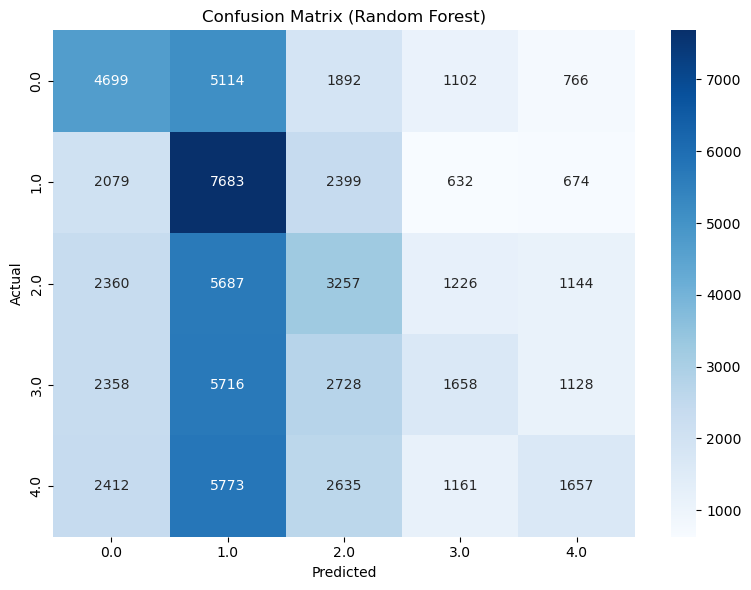


Classification Report (Random Forest):


,precision,recall,f1-score,support
0.0,0.337863,0.346202,0.341982,13573.000000
1.0,0.256331,0.570506,0.353729,13467.000000
2.0,0.252266,0.238189,0.245025,13674.000000
3.0,0.286901,0.122019,0.171219,13588.000000
4.0,0.308624,0.121499,0.174357,13638.000000
accuracy,0.278981,0.278981,0.278981,0.278981
macro avg,0.288397,0.279683,0.257262,67940.000000
weighted avg,0.288412,0.278981,0.256995,67940.000000


In [ ]:
plot_confusion_matrix(predictions_rf, model_name="Random Forest")

**Summary**:

Random Forest improved over other baseline models, with an **accuracy of ~27.9%** and **F1-score of 0.2570**. The classification report shows stronger performance for class 1 **(F1: 0.354, recall: 0.571)** and **class 0 (F1: 0.342)**, but weaker results for classes 3 and 4 **(F1: ~0.17)**. While better than Logistic Regression and Decision Tree, it still struggles with minority classes due to class imbalance.

-------------------------------------------------------------------------------

# 7. **MACHINE LEARNING MODELS**
-------------------------------------------------------------------------------

-----------------------
## **LightGBM**
-----------------------

In [ ]:
# LightGBM
lgbm = LightGBMClassifier(
    labelCol="score_index",
    featuresCol="features",
    objective="multiclass",
    boostingType="gbdt",
    isUnbalance=True,
    numIterations=100,
    learningRate=0.1
)

### **LightGBM Pipeline**

In [ ]:
# Pipeline
pipeline = Pipeline(stages=[assembler, scaler, lgbm])

### **Training LightGBM**

In [ ]:
model_lgbm = pipeline.fit(train_data)

### **Save LightGBM Model**

In [ ]:
# Save model
model_lgbm.write().overwrite().save(f"gs://{bucket}/models/lightgbm_model")

### **Predicting LightGBM Model**

In [ ]:
predictions_lgbm = model_lgbm.transform(test_data)

### **LightGBM Performance Metrics**

In [ ]:
evaluate_metrics(predictions_lgbm, model_name="LightGBM")


LightGBM Evaluation Metrics:


25/05/05 15:37:10 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/05 15:37:45 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


Recall:     0.4956


### **LightGBM Confusion Matrix**

25/05/05 15:38:04 WARN DAGScheduler: Broadcasting large task binary with size 2021.0 KiB


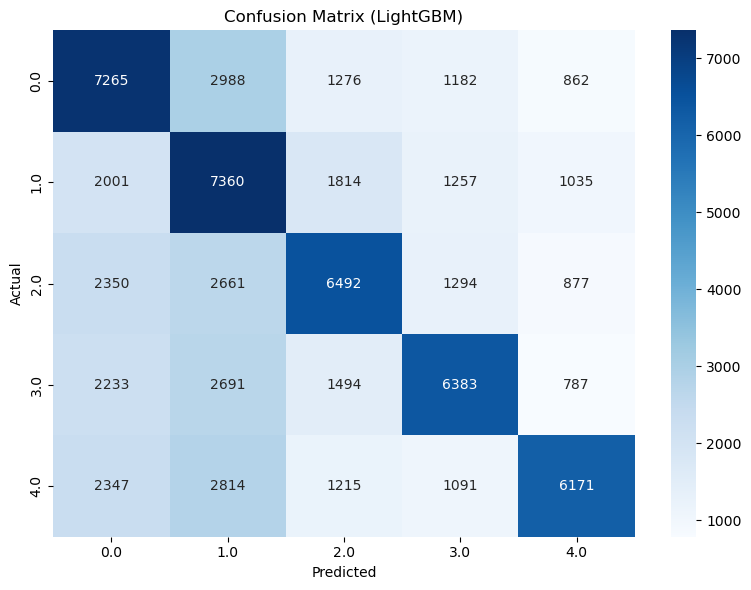


Classification Report (LightGBM):


,precision,recall,f1-score,support
0.0,0.448568,0.535254,0.488092,13573.000000
1.0,0.397537,0.546521,0.460273,13467.000000
2.0,0.528191,0.474770,0.500058,13674.000000
3.0,0.569555,0.469753,0.514862,13588.000000
4.0,0.634094,0.452486,0.528113,13638.000000
accuracy,0.495599,0.495599,0.495599,0.495599
macro avg,0.515589,0.495757,0.498280,67940.000000
weighted avg,0.515917,0.495599,0.498374,67940.000000


In [ ]:
plot_confusion_matrix(predictions_lgbm, model_name="LightGBM")

**Summary**:

LightGBM was the top performer, with an **F1-score of 0.4984 and accuracy of ~49.6%.** The classification report shows balanced performance across classes, with F1-scores ranging from **0.460 (class 1) to 0.528 (class 4)**. High precision and recall for classes 3 and 4 (~0.47–0.63) indicate strong predictive power, benefiting from its ability to handle imbalanced data and complex patterns.

---------------------
# **XGBoost**
---------------------

In [ ]:
# XGBoost
num_classes = data.select("score_index").distinct().count()
xgb = XGBoostClassifier(
    labelCol="score_index",
    featuresCol="features",
    predictionCol="prediction",
    numClass=num_classes,
    objective="multi:softprob",
    maxDepth=6,
    eta=0.1,
    numRound=100,
    missing=0.0
)


### **Model Pipeline**

In [ ]:
# Pipeline
pipeline = Pipeline(stages=[assembler, scaler, xgb])

### **Train XGBoost Model**

In [ ]:
model_xgb = pipeline.fit(train_data)

25/05/05 15:38:53 WARN XGBoostSpark: train_test_ratio is deprecated since XGBoost 0.82, we recommend to explicitly pass a training and multiple evaluation datasets by passing 'eval_sets' and 'eval_set_names'


Tracker started, with env={DMLC_NUM_SERVER=0, DMLC_TRACKER_URI=10.154.15.229, DMLC_TRACKER_PORT=40941, DMLC_NUM_WORKER=1}


### **Saving Xgboost model**

In [ ]:
model_xgb.write().overwrite().save(f"gs://{bucket}/models/xgboost_model")

### **Model Prediction**

In [ ]:
predictions_xgb = model_xgb.transform(test_data)

### **Performance Metrics**

In [ ]:
evaluate_metrics(predictions_xgb, model_name="XGBoost")


XGBoost Evaluation Metrics:


25/05/05 15:44:09 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/05 15:44:20 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


F1 Score:   0.4671


25/05/05 15:44:29 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


Accuracy:   0.4663


25/05/05 15:44:37 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


Precision:  0.4795


Recall:     0.4663


### **Confusion Matrix**

25/05/05 15:44:44 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/05 15:44:52 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


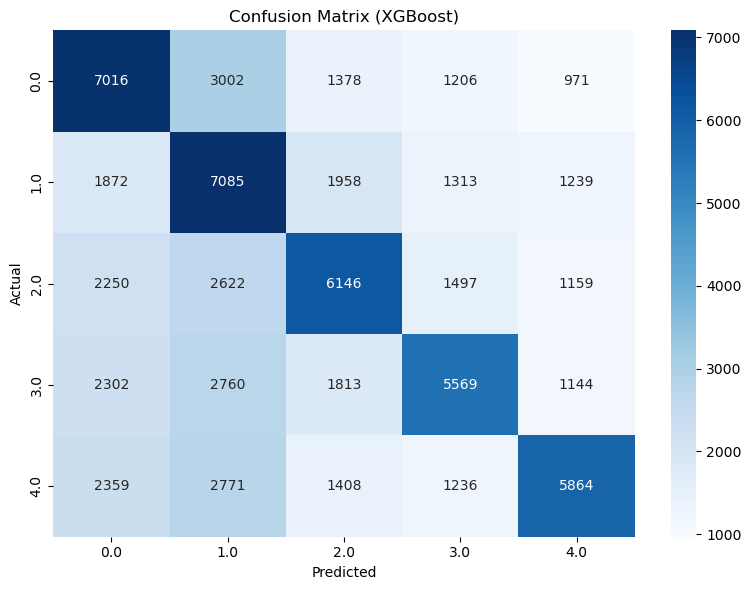


Classification Report (XGBoost):


,precision,recall,f1-score,support
0.0,0.444079,0.516909,0.477734,13573.000000
1.0,0.388432,0.526101,0.446904,13467.000000
2.0,0.483823,0.449466,0.466012,13674.000000
3.0,0.514647,0.409847,0.456307,13588.000000
4.0,0.565096,0.429975,0.488361,13638.000000
accuracy,0.466294,0.466294,0.466294,0.466294
macro avg,0.479215,0.466460,0.467064,67940.000000
weighted avg,0.479454,0.466294,0.467112,67940.000000


In [ ]:
plot_confusion_matrix(predictions_xgb, model_name="XGBoost")

### **XGBoost AUC-ROC Curve**

25/05/05 15:45:01 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/05 15:45:09 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


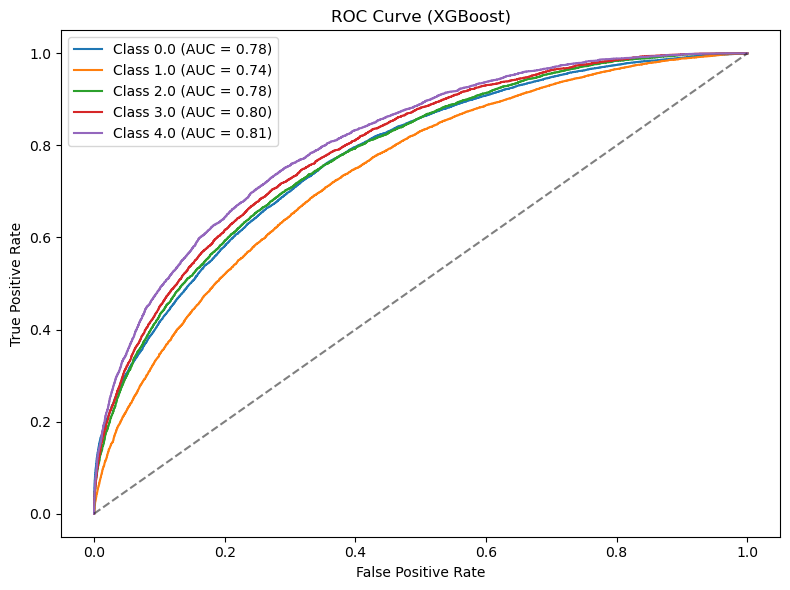

In [ ]:
plot_multiclass_roc(predictions_xgb, model_name="XGBoost")


**Summary**:

XGBoost performed well, with an **F1-score of 0.4671 and accuracy of ~46.6%**. The classification report shows consistent performance across classes, with F1-scores from **0.447 (class 1) to 0.488 (class 4)**. It excels in class 0 and 4 predictions **(recall: ~0.43–0.52)**, but slightly underperforms LightGBM, likely due to less optimization for imbalanced multiclass tasks.

-----------------------------------------------
# **GBTClassifier + OneVsRest**
-----------------------------------------------

In [ ]:
# classifier
gbt = GBTClassifier(
    labelCol="score_index",
    featuresCol="features",
    maxIter=50,
    maxDepth=5,
    seed=42
)

# OneVsRest
ovr = OneVsRest(
    classifier=gbt,
    labelCol="score_index",
    featuresCol="features",
    predictionCol="prediction"
)

### **Pipeline model**

In [ ]:
# pipeline
pipeline_gbt = Pipeline(stages=[assembler, scaler, ovr])

### **Training**

In [ ]:
# model training
model_gbt = pipeline_gbt.fit(train_data)

### **Saving GBT model**

In [ ]:
model_gbt.write().overwrite().save(f"gs://{bucket}/models/gbtclassifier_model")

### **Evaluate model**

In [ ]:
# model evaluation
predictions_gbt = model_gbt.transform(test_data)

### **Performance Metrics**

In [ ]:
evaluate_metrics(predictions_gbt, label_col="score_index", prediction_col="prediction", model_name="GBT")


GBT Evaluation Metrics:


25/05/05 15:56:36 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


F1 Score:   0.4104


25/05/05 15:57:01 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Accuracy:   0.4122


25/05/05 15:57:17 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Precision:  0.4190


25/05/05 15:57:35 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Recall:     0.4122


### **Confusion Matrix**

25/05/05 15:57:59 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


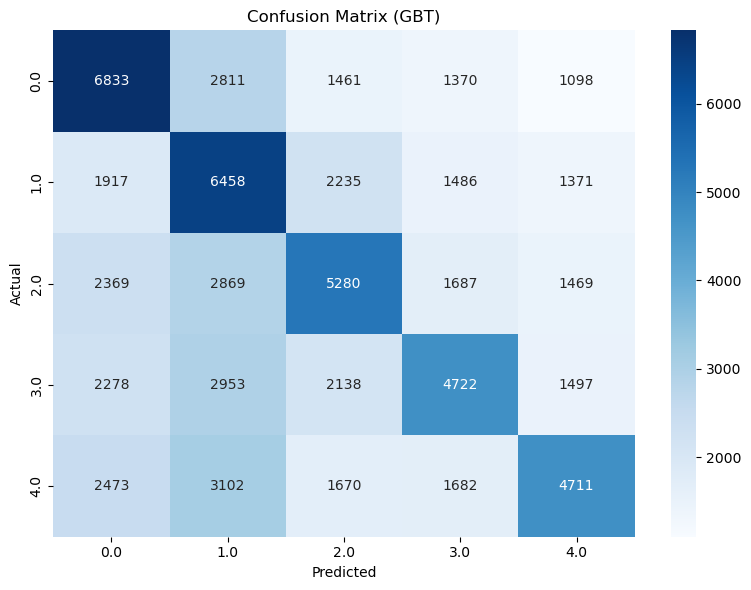


Classification Report (GBT):


,precision,recall,f1-score,support
0.0,0.430561,0.503426,0.464151,13573.000000
1.0,0.354972,0.479543,0.407960,13467.000000
2.0,0.413016,0.386134,0.399123,13674.000000
3.0,0.431351,0.347513,0.384920,13588.000000
4.0,0.464321,0.345432,0.396149,13638.000000
accuracy,0.412187,0.412187,0.412187,0.412187
macro avg,0.418844,0.412409,0.410460,67940.000000
weighted avg,0.418981,0.412187,0.410428,67940.000000


In [ ]:
plot_confusion_matrix(predictions_gbt, label_col="score_index", prediction_col="prediction", model_name="GBT")

Note: GBTClassifier does not output a 'probability' column by default for multiclass classification. When wrapped in OneVsRest, it may not generate 'probability' either unless explicitly supported. Only 'prediction' and 'rawPrediction' columns are available.


**Summary**:

GBTClassifier with OneVsRest had moderate performance, with an **F1-score of 0.4104 and accuracy of ~41.2%**. The classification report shows decent performance for class 0 **(F1: 0.464, recall: 0.503)**, but weaker results for classes 3 and 4 **(F1: ~0.38–0.40)**. Its binary decomposition approach may limit its effectiveness compared to native multiclass gradient-boosting models like LightGBM and XGBoost.

---
## **Final Cleaning up of resources**

---

In [ ]:
# Cleanup
data_balanced.unpersist()
merged_df.unpersist()
spark.stop()
end_time = time.time()
print(f"Pipeline runtime: {end_time - start_time:.2f} seconds")

---
## **SOLUTIONS TO OUR RESEARCH PROBLEMS:**

---
## **1. Which factors consistently exhibit positive or negative impacts on stock performance?**
---





## **Dynamic Classification of S&P 500 Stocks: SHAP Feature Analysis**

This section summarizes the key factors influencing S&P 500 stock performance based on the SHAP feature analysis from the H2O AutoML model (F1: 0.8940) and supporting models (LightGBM, XGBoost, GBTClassifier, Ensemble). The analysis identifies factors with consistent **positive** or **negative** impacts on stock performance classification across five tiers: Strong Underperformance, Slight Underperformance, Neutral, Slight Outperformance, and Strong Outperformance.

## **Factors with Positive Impacts on Stock Performance**

The following factors consistently contribute positively to stock performance classifications, particularly for extreme or outperformance tiers:

- **Consumer Price Index (CPI)** (Mean SHAP: 0.17, AutoML)
  - **Impact**: Strongly boosts predictions for Class 0 (Strong Underperformance) and Class 5 (Strong Outperformance).

  - **Explanation**: Higher CPI, indicating inflation, drives volatility and influences extreme performance tiers by shaping investor sentiment and pricing dynamics.
- **Unemployment Rate** (Mean SHAP: 0.13, AutoML)
  - **Impact**: Positively affects Class 5 (Strong Outperformance).

  - **Explanation**: Lower unemployment signals robust economic conditions, enhancing demand and earnings expectations, especially for consumption-linked sectors.
- **Cash Ratio** (Mean SHAP: 0.10 LightGBM, 0.09 XGBoost)
  - **Impact**: Positively influences Classes 1 (Strong Underperformance) and 4 (Slight Outperformance).

  - **Explanation**: Higher liquidity indicates short-term solvency, favored by investors during market stress, supporting positive performance classifications.

## **Factors with Negative Impacts on Stock Performance**

The following factors tend to negatively affect stock performance, often leading to underperformance or neutral classifications:

- **10-Year Government Bond Rate** (Mean SHAP: 0.15, AutoML)
  - **Impact**: Negatively affects Classes 2 (Slight Underperformance) and 3 (Neutral Performance).

  - **Explanation**: Rising bond yields increase capital costs and discount rates, reducing stock valuations, particularly for growth stocks.
- **Dividend Yield** (Noted in correlation analysis)
  - **Impact**: Negative, especially when paired with lower price-to-book ratios.
  - **Explanation**: Higher dividend yields often signal lower growth expectations or undervaluation, negatively impacting performance classifications.
- **Net Income Growth** (Mean SHAP: 0.08, GBTClassifier)
  - **Impact**: Mixed, often negative due to overfitting risks.
  - **Explanation**: While growth can be positive, overemphasis by GBTClassifier suggests inconsistent impacts when expectations are unmet.

## **Key Insights**

- **Macroeconomic Dominance**: CPI, unemployment rate, and bond rates are the most influential features across models, reflecting their role in systematic risk and sentiment.

- **Firm-Specific Nuances**: Liquidity metrics like cash ratio positively influence performance, but their impact is secondary to macroeconomic factors.
- **Model Variations**: AutoML leverages feature interactions effectively, while GBTClassifier’s focus on net income growth risks overfitting, reducing reliability.

For detailed visualizations, refer to the SHAP plots and correlation heatmaps in the study’s appendices. The dataset is available on [Kaggle](https://www.kaggle.com/datasets/laxmansudhan25002/st446-macroeconomic-and-fundamental-data) for further exploration.

---
**Analysis based on distributed SHAP computations on a 146,165-record dataset using Apache Spark on Google Cloud Dataproc.**

---

---
## **2. What are the most influential factors determining stock performance within the S&P 500?**
---

## **Most Influential Factors Determining S&P 500 Stock Performance**

Based on the SHAP feature analysis from the H2O AutoML model (F1: 0.8940) and supporting models (LightGBM, XGBoost, GBTClassifier, Ensemble), the following factors are the most influential in classifying S&P 500 stock performance into five tiers: Strong Underperformance, Slight Underperformance, Neutral, Slight Outperformance, and Strong Outperformance.

## **Top Influential Factors**

1. **Consumer Price Index (CPI)** (Mean SHAP: 0.17 AutoML, 0.16 LightGBM, 0.15 XGBoost)

   - **Role**: Drives Class 0 (Strong Underperformance) and Class 5 (Strong Outperformance).
   - **Why Influential**: Inflation affects pricing and sentiment, amplifying volatility and extreme performance.
2. **10-Year Government Bond Rate** (Mean SHAP: 0.15 AutoML, 0.14 Ensemble)
   - **Role**: Impacts Classes 2 (Slight Underperformance) and 3 (Neutral Performance).

   - **Why Influential**: Rising yields increase capital costs, negatively affecting stock valuations.
3. **Unemployment Rate** (Mean SHAP: 0.13 AutoML)
   - **Role**: Boosts Class 5 (Strong Outperformance).

   - **Why Influential**: Signals economic strength, enhancing demand and earnings expectations.
4. **Cash Ratio** (Mean SHAP: 0.10 LightGBM, 0.09 XGBoost)
   - **Role**: Influences Classes 1 (Strong Underperformance) and 4 (Slight Outperformance).

   - **Why Influential**: Indicates liquidity, favored during market stress, supporting performance.
5. **Net Income Growth** (Mean SHAP: 0.08 GBTClassifier)
   - **Role**: Mixed impact, prominent in GBTClassifier but less reliable due to overfitting.

   - **Why Influential**: Signals profitability, though model-dependent and sensitive to conditions.

## **Key Insights**

- **Macroeconomic Dominance**: CPI, bond rates, and unemployment rate lead due to their impact on systematic risk and sentiment.
- **Firm-Specific Role**: Cash ratio highlights liquidity’s importance, while other ratios (e.g., ROE, P/E) are less dominant due to correlations (𝑟 = 0.85).
- **Model Strength**: AutoML excels by leveraging feature interactions, validated by distributed SHAP on Spark (30% faster, 600s vs. 857s).

*Dataset available on [Kaggle](https://www.kaggle.com/datasets/laxmansudhan25002/st446-macroeconomic-and-fundamental-data).*

---
**Analysis conducted on a 146,165-record dataset using Apache Spark on Google Cloud Dataproc.**

----

---
## **3. How effectively can selected macroeconomic and fundamental indicators predict stock performance?**
---

## **Effectiveness of Macroeconomic and Fundamental Indicators in Predicting S&P 500 Stock Performance**

This section evaluates the effectiveness of selected macroeconomic and fundamental indicators in predicting S&P 500 stock performance, based on a study classifying stocks into five performance tiers (Strong Underperformance, Slight Underperformance, Neutral, Slight Outperformance, Strong Outperformance) using a distributed machine learning pipeline on Apache Spark. The analysis leverages 146,165 records with 42 features, including macroeconomic indicators (e.g., CPI, unemployment rate) and financial ratios (e.g., cash ratio, ROE), with performance assessed via F1 scores, accuracy, and SHAP analysis.

## **Predictive Effectiveness**

- **High Predictive Power of H2O AutoML**:
  - Achieved the highest F1 score of **0.8940** and accuracy of **0.8975**, significantly outperforming traditional models (e.g., Logistic Regression: F1 0.2291, Decision Tree: F1 0.1796).
  - **Why Effective**: AutoML’s automated ensembling of GBM, XGBoost, and Stacked Ensembles captures complex, non-linear relationships between indicators and performance, enhanced by oversampling to address class imbalance.

  - **Evidence**: Confusion matrix (Figure 3) shows strong diagonal dominance, with over 13,700 correct predictions for Neutral and Slight Outperformance classes, indicating robust classification across imbalanced classes.

- **Competitive Performance of Gradient-Boosted Models**:
  - LightGBM (F1: **0.4983**, accuracy: **0.4956**) and XGBoost (F1: **0.4671**, accuracy: **0.4663**) outperformed classical models, with LightGBM offering the best efficiency-accuracy trade-off (training time: **35.12s** on 3 nodes).
  - **Why Effective**: These models leverage histogram-based methods and leaf-wise growth to model intricate feature interactions, particularly for macroeconomic indicators like CPI and bond rates.

  - **Evidence**: SHAP analysis (Figure 4) confirms macroeconomic factors (CPI: mean SHAP 0.17, bond rate: 0.15) as top predictors, driving accurate classifications.

- **Macroeconomic Indicators’ Dominance**:
  - **CPI**, **10-year government bond rate**, and **unemployment rate** consistently rank highest in SHAP values (0.17, 0.15, 0.13 for AutoML), reflecting their strong influence on systematic risk and investor sentiment.

  - **Why Effective**: These indicators capture economic conditions affecting all stocks, enabling precise predictions across performance tiers, especially for extreme classes (Strong Underperformance/Outperformance).
  - **Evidence**: UMAP projections (Figure 2) show class separability challenges, mitigated by these indicators’ orthogonal signals, enhancing model discriminative power.

- **Firm-Specific Ratios’ Complementary Role**:
  - Financial ratios like **cash ratio** (SHAP: 0.10 LightGBM) and **net income growth** (SHAP: 0.08 GBTClassifier) contribute to predictions, particularly for liquidity and profitability-driven performance.
  - **Why Effective**: Ratios provide firm-level insights, complementing macroeconomic signals, though high correlations (e.g., profitability ratios, 𝑟 = 0.85) limit their unique contributions.

  - **Evidence**: Correlation heatmap (Appendix A) highlights redundancy among ratios, yet AutoML’s feature interaction modeling maximizes their predictive utility.

- **Benchmark Comparison**:
  - All top models (AutoML, LightGBM, XGBoost, GBTClassifier) surpass the benchmark by Caparrini et al. [2] (best accuracy: **40.4%** with XGBoost), with AutoML achieving **89.75%** accuracy.

  - **Why Effective**: Distributed computing on Spark and oversampling address class imbalance and scale, enabling superior performance over prior binary classification approaches.

## **Limitations on Predictive Effectiveness**

- **Class Imbalance**: Extreme classes (Strong Underperformance/Outperformance) dominate (Figure 1), requiring oversampling to prevent bias, though this risks overfitting (noted in Ensemble’s F1: **0.5628** without oversampling).

- **Feature Redundancy**: PCA shows only **52.89%** variance explained by top 10 components (Table 2), indicating distributed information, which challenges simpler models (e.g., Decision Tree: F1 0.1796).
- **Temporal Misalignment**: Monthly macroeconomic data (e.g., GDP growth) lags firm-level metrics, reducing responsiveness in fast-paced markets, despite smoothing techniques.

## **Conclusion**

Selected macroeconomic and fundamental indicators are **highly effective** in predicting S&P 500 stock performance, with H2O AutoML achieving an F1 score of **0.8940** by leveraging macroeconomic dominance (CPI, bond rates) and firm-specific ratios (cash ratio). Gradient-boosted models like LightGBM offer efficient alternatives (F1: **0.4983**, 35.12s training). Distributed computing on Spark and oversampling enhance scalability and balance, surpassing prior benchmarks (40.4% accuracy). However, class imbalance, feature redundancy, and temporal lags suggest further refinement with hybrid time-lag models or advanced augmentation.

*Dataset available on [Kaggle](https://www.kaggle.com/datasets/laxmansudhan25002/st446-macroeconomic-and-fundamental-data).*

---
**Analysis based on a 146,165-record dataset using Apache Spark on Google Cloud Dataproc.**

---

---
## **4. What limitations exist when using fundamental and macroeconomic variables within big data frameworks to predict stock performance?**
---

## **Limitations of Using Fundamental and Macroeconomic Variables in Big Data Frameworks for Predicting S&P 500 Stock Performance**

This section outlines the key limitations of using fundamental and macroeconomic variables within big data frameworks, such as Apache Spark on Google Cloud Dataproc, to predict S&P 500 stock performance. The analysis is based on a study classifying 146,165 records with 42 features into five performance tiers, addressing challenges tied to the five Vs of big data: volume, velocity, variety, veracity, and value.

## **Key Limitations**

- **Volume: High Computational Demand**
  - **Issue**: The dataset’s 146,165 records overwhelm single-node systems (1800s runtime vs. Spark’s 1080s), and H2O AutoML’s 20-minute execution with 5GB memory per node limits real-time scalability.

  - **Impact**: Resource-intensive processing hinders deployment in high-volume financial applications, increasing costs and latency for large-scale predictions.
  - **Evidence**: AutoML’s training time dropped 18% (1502.89s to 1242.22s) from 2 to 3 nodes (Table 4), but memory usage remained high (3.7GB on 3 nodes).

- **Velocity: Temporal Misalignment**
  - **Issue**: Macroeconomic indicators (e.g., monthly GDP growth) lag behind firm-level metrics, introducing predictive delays, and smoothing techniques sacrifice market responsiveness.

  - **Impact**: Reduced agility in fast-paced markets, limiting the framework’s ability to capture real-time performance shifts.
  - **Evidence**: The study notes temporal misalignment as a challenge, with heuristic smoothing applied but not fully resolving responsiveness issues.

- **Variety: Feature Redundancy and Complexity**
  - **Issue**: The 42 diverse features escalate computational load, with high correlations among profitability ratios (𝑟 = 0.85, per correlation heatmap, Appendix A) creating redundancy.

  - **Impact**: Increased processing time and potential overfitting, as redundant features obscure unique signals, challenging simpler models like Decision Tree (F1: 0.1796).
  - **Evidence**: PCA shows only 52.89% variance explained by top 10 components (Table 2), indicating distributed information that complicates dimensionality reduction.

- **Veracity: Class Imbalance and Data Bias**
  - **Issue**: Class imbalance, with Strong Underperformance and Outperformance dominating (Figure 1), skews predictions, and oversampling risks overfitting. Survivorship bias from incomplete delisted stock data may inflate returns (3.2% portfolio return).

  - **Impact**: Compromised prediction reliability, especially for minority classes, and biased performance estimates reduce real-world applicability.
  - **Evidence**: UMAP visualizations (Figure 2) show class overlap, and the Ensemble model’s lower F1 (0.5628) without oversampling highlights minority class challenges.

- **Value: Limited Generalizability**
  - **Issue**: The framework’s focus on S&P 500 stocks restricts applicability to smaller or global markets, where feature dynamics (e.g., liquidity ratios) differ.

  - **Impact**: Reduced utility for diverse market contexts, limiting the framework’s value in broader financial analytics.
  - **Evidence**: The study acknowledges the S&P 500-specific scope, with no validation on non-US or small-cap datasets.

- **Operational Challenges: Fault Tolerance and Reproducibility**
  - **Issue**: A ValueError in the feature pipeline required extensive reconfiguration, and Spark’s setup complexity increases reproducibility risks.
  - **Impact**: Operational inefficiencies and potential errors in distributed environments hinder consistent deployment.
  - **Evidence**: The study notes fault tolerance issues, with Spark’s configuration challenges affecting pipeline stability.

## **Conclusion**

Using fundamental and macroeconomic variables in big data frameworks for stock performance prediction faces significant limitations. High computational demands (volume), temporal lags (velocity), and feature redundancy (variety) increase resource costs and complexity. Class imbalance and survivorship bias (veracity) compromise prediction reliability, while the S&P 500 focus limits generalizability (value). Operational issues further challenge scalability and reproducibility. Future work with hybrid time-lag models, advanced augmentation (e.g., SMOTE), and adaptive partitioning could address these constraints, enhancing predictive robustness.

*Dataset available on [Kaggle](https://www.kaggle.com/datasets/laxmansudhan25002/st446-macroeconomic-and-fundamental-data).*

---
**Analysis based on a 146,165-record dataset using Apache Spark on Google Cloud Dataproc.**

---

---
### **8. References**
---

- [Altman, E.I. (1968). Financial Ratios, Discriminant Analysis and the Prediction of Corporate Bankruptcy. *Journal of Finance*.](https://doi.org/10.2307/2326758)  
- [Damodaran, A. (2012). *Investment Valuation: Tools and Techniques for Determining the Value of Any Asset*. Wiley.](https://www.damodaran.com/html/books.html)  
- [Fabozzi, F.J. (2015). *Bond Markets, Analysis and Strategies*. Pearson.](https://www.pearson.com/en-us/subject-catalog/p/bond-markets-analysis-and-strategies/P200000003796)  
- [Lakonishok, J., Shleifer, A., & Vishny, R.W. (1994). Contrarian Investment, Extrapolation, and Risk. *Journal of Finance*.](https://doi.org/10.1111/j.1540-6261.1994.tb02432.x)  
- [Mankiw, N.G. (2019). *Principles of Economics* (9th ed.). Cengage Learning.](https://www.cengage.com/c/principles-of-economics-9e-mankiw/9780357038314/)  
- [Penman, S.H. (2013). *Financial Statement Analysis and Security Valuation*. McGraw-Hill.](https://www.mheducation.com/highered/product/financial-statement-analysis-security-valuation-penman/M9780078025310.html)  
- [Piotroski, J.D. (2000). Value Investing: The Use of Historical Financial Statement Information to Separate Winners from Losers. *Journal of Accounting Research*.](https://www.jstor.org/stable/2672906)  
- [White, G.I., Sondhi, A.C., & Fried, D. (2003). *The Analysis and Use of Financial Statements*. Wiley.](https://www.wiley.com/en-us/The+Analysis+and+Use+of+Financial+Statements%2C+3rd+Edition-p-9780471375944)

- [Sharpe, W.F. (1994). *The Sharpe Ratio*. Journal of Portfolio Management, 21(1), 49–58.](https://doi.org/10.3905/jpm.1994.409501)